###### Python Libraries

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats

###### Visualization libraries

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

###### ML Libraries

In [47]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
train = pd.read_csv('TRAIN.csv')
test = pd.read_csv('TEST.csv')
train.drop('Index',axis = 1, inplace = True)
test.drop('Index',axis = 1, inplace = True)

In [5]:
fraud = train[train['Class']==1]
nofraud = train[train['Class']!=1].sample(660,random_state = 3435) #660 is best with 0.1 test_size down
data = pd.DataFrame(np.vstack((fraud,nofraud)),columns = train.columns)
data = data.sample(frac = 1).reset_index()
data.drop('index',axis = 1,inplace = True)

In [6]:
data['Class'].value_counts(normalize = True)

0.0    0.6
1.0    0.4
Name: Class, dtype: float64

In [7]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# model = ols("Class~V1+V2+V3+V4+V5+V6+V7+V8+V9+V10+V11+V12+V13+V14+V15+V16+V17+V18+V19+V20+V21+V22+V23+V24+V25+V26+V27+V28+Amount",data = data).fit()
# an = sm.stats.anova_lm(model)
# an[an.loc[:,'PR(>F)']>0.05]

In [8]:
# dropping = ['V24']
# data1 = data.drop(dropping,axis = 1)

# Bag_KNN

In [9]:
ss = StandardScaler()
X = data.drop('Class',axis = 1)
X_Scaled = ss.fit_transform(X)
X_test_Scaled = ss.fit_transform(test)
y = data['Class']
x_train,x_test,y_train,y_test = train_test_split(X_Scaled,y,test_size = 0.1)

In [10]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((990, 29), (110, 29), (990,), (110,))

In [11]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [12]:
knn.score(x_test,y_test)

0.9181818181818182

In [13]:
grid_param = {
    'leaf_size': [10,20,30,40],
    'n_neighbors': [2,3,4,5,6,7,8,9,10],
    'p': [1,2]
    
}
grid_search = GridSearchCV(estimator = knn,param_grid = grid_param,cv = 5,n_jobs = -1)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'leaf_size': [10, 20, 30, 40],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [14]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'leaf_size': 10, 'n_neighbors': 7, 'p': 1}


In [15]:
bag_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors = best_parameters['n_neighbors'],p = best_parameters['p'],leaf_size = best_parameters['leaf_size']),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3,oob_score=True) 

In [16]:
bag_knn.fit(x_train, y_train)
bag_knn.score(x_test, y_test)

0.9454545454545454

Precision: 0.9230769230769231
Recall: 1.0


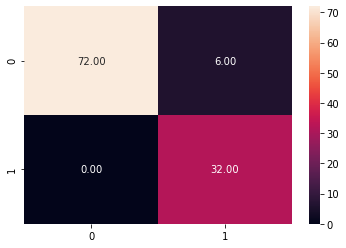

In [17]:
y_pred = bag_knn.predict(x_test)
cmatrix = confusion_matrix(y_pred,y_test)
sns.heatmap(cmatrix,annot = True,fmt = '.2f')
prec = cmatrix[0][0]/(cmatrix[0][0]+cmatrix[0][1])
recal = cmatrix[0][0]/(cmatrix[0][0]+cmatrix[1][0])
print('Precision: {}'.format(prec))
print('Recall: {}'.format(recal))

In [18]:
test_scaled = ss.fit_transform(test)
pred = bag_knn.predict(test_scaled)
subm = pd.DataFrame(pred,columns = ['Class'])
subm['Class'] = subm['Class'].astype(int) 
subm.to_csv('submissions/submissionbag_knn.csv',index= True,index_label = 'Index')

# Random Forest

In [33]:
ss = StandardScaler()
X = data.drop('Class',axis = 1)
X_Scaled = ss.fit_transform(X)
X_test_Scaled = ss.fit_transform(test)
y = data['Class']
x_train,x_test,y_train,y_test = train_test_split(X_Scaled,y,test_size = 0.2)

In [34]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((880, 29), (220, 29), (880,), (220,))

In [35]:
rand_clf = RandomForestClassifier(random_state=12)
rand_clf.fit(x_train,y_train)
rand_clf.score(x_test,y_test)

C:\Users\tejas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9227272727272727

In [38]:
grid_param = {
    "n_estimators" : [90,100,115,120],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split': [10,20],
    'max_features' : ['auto','log2']
}

In [39]:
grid_search = GridSearchCV(estimator=rand_clf,param_grid=grid_param,cv=5,n_jobs =-1,verbose = 3)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=12,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criter

In [40]:
grid_search.best_params_

{'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 115}

In [41]:
rand_clf = RandomForestClassifier(criterion= 'gini',
 max_features = 'log2',
 min_samples_leaf = 1,
 min_samples_split= 10,
 n_estimators = 115)

In [42]:
rand_clf.fit(x_train,y_train)
rand_clf.score(x_test,y_test)

0.9227272727272727

Precision: 0.9117647058823529
Recall: 0.9612403100775194


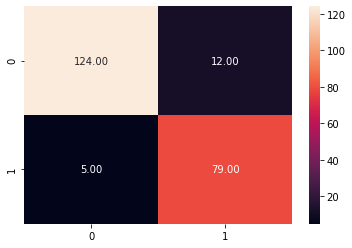

In [44]:
y_pred = rand_clf.predict(x_test)
cmatrix = confusion_matrix(y_pred,y_test)
sns.heatmap(cmatrix,annot = True,fmt = '.2f')
prec = cmatrix[0][0]/(cmatrix[0][0]+cmatrix[0][1])
recal = cmatrix[0][0]/(cmatrix[0][0]+cmatrix[1][0])
print('Precision: {}'.format(prec))
print('Recall: {}'.format(recal))

In [ ]:
test_scaled = ss.fit_transform(test)
pred = rand_clf.predict(test_scaled)
subm = pd.DataFrame(pred,columns = ['Class'])
subm['Class'] = subm['Class'].astype(int) 
subm.to_csv('submissions/submissionrand_for.csv',index= True,index_label = 'Index')